# Session 2: ARCH and GARCH Models

## Course: Advanced Volatility Modeling

---

## Learning Objectives

By the end of this session, students will be able to:
1. Derive and understand the ARCH model and its properties
2. Extend to GARCH and understand the relationship to ARMA processes
3. Estimate GARCH models using maximum likelihood
4. Perform model diagnostics and selection
5. Generate volatility forecasts

---

## 1. The ARCH Model

### 1.1 Motivation

From Session 1, we established that financial returns exhibit **volatility clustering**: large returns tend to be followed by large returns. This means variance is **time-varying** and **predictable**.

Engle (1982) introduced the **AutoRegressive Conditional Heteroskedasticity (ARCH)** model to capture this phenomenon.

### 1.2 Model Specification

Let $r_t$ be the return at time $t$. The ARCH(q) model specifies:

$$r_t = \mu + \epsilon_t$$

where $\epsilon_t = \sigma_t z_t$ with $z_t \overset{iid}{\sim} (0,1)$, and:

$$\boxed{\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2}$$

**Key insight**: Conditional variance $\sigma_t^2$ depends on past squared shocks.

### 1.3 Properties of ARCH(q)

**Conditional distribution**:
$$\epsilon_t | \mathcal{F}_{t-1} \sim (0, \sigma_t^2)$$

**Unconditional variance** (assuming stationarity):
$$E[\epsilon_t^2] = \frac{\omega}{1 - \sum_{i=1}^{q} \alpha_i}$$

This requires $\sum_{i=1}^{q} \alpha_i < 1$ for stationarity.

**Unconditional kurtosis** for ARCH(1):
$$\kappa = \frac{E[\epsilon_t^4]}{(E[\epsilon_t^2])^2} = 3 \cdot \frac{1 - \alpha_1^2}{1 - 3\alpha_1^2}$$

This exceeds 3 (excess kurtosis > 0), explaining the heavy tails!

### 1.4 ARCH(1) as AR(1) in Squared Returns

Define $\nu_t = \epsilon_t^2 - \sigma_t^2$ (conditional variance "surprise"). Then:

$$\epsilon_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \nu_t$$

This is an AR(1) process in $\epsilon_t^2$! The autocorrelation of squared returns is:

$$\rho_k(\epsilon^2) = \alpha_1^k$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.stats import norm, t as student_t
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

np.random.seed(42)

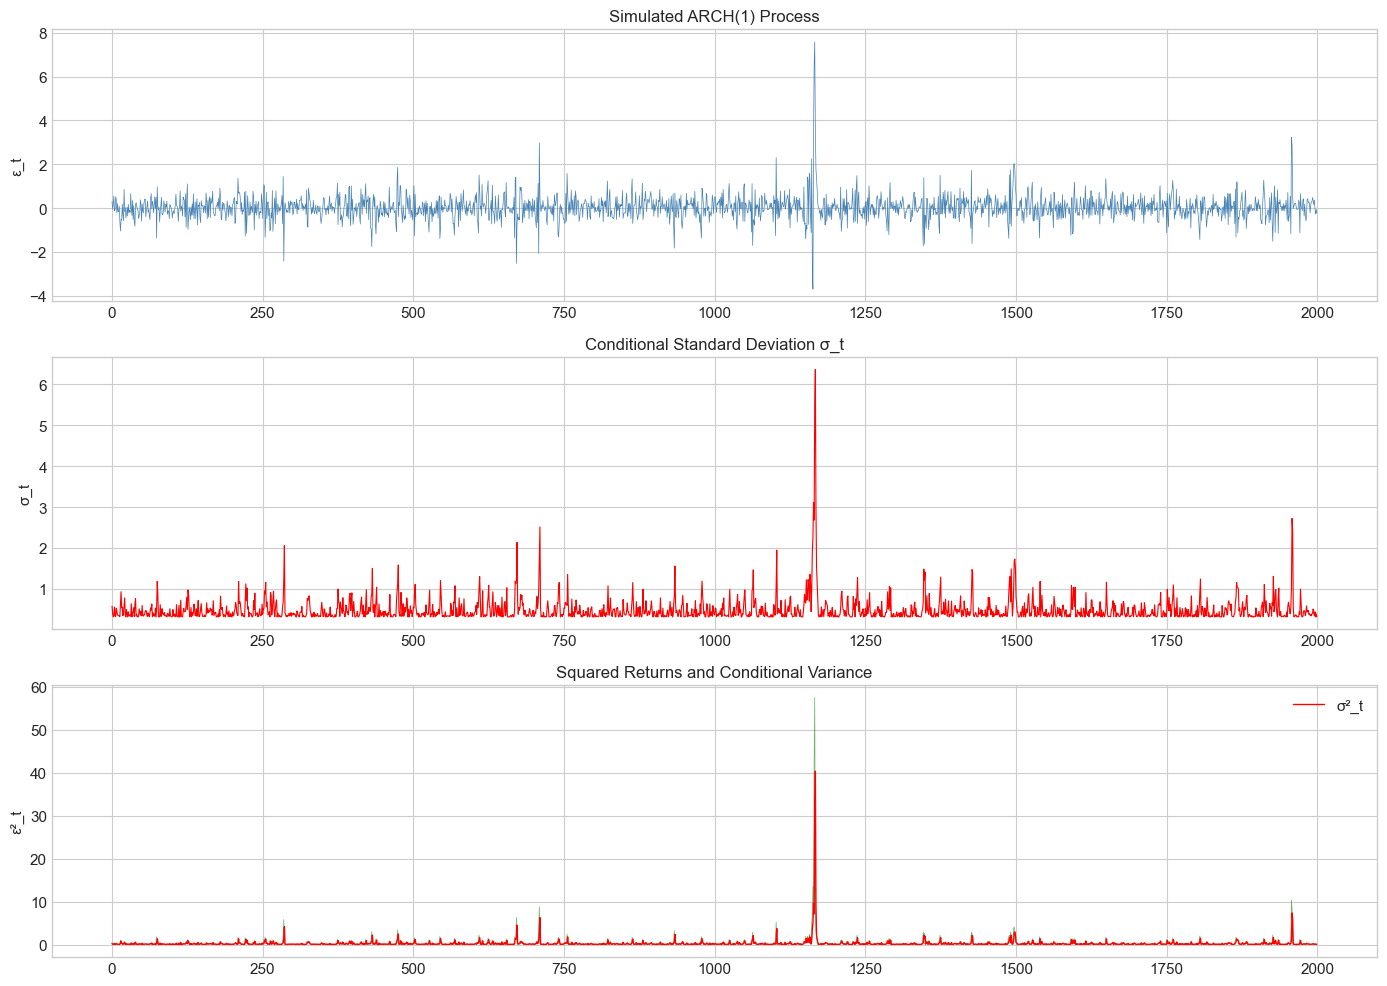

In [3]:
def simulate_arch(n, omega, alphas, dist='normal', df=5):
    """
    Simulate ARCH(q) process.
    
    Parameters
    ----------
    n : int
        Number of observations
    omega : float
        Constant term (must be positive)
    alphas : array-like
        ARCH coefficients [alpha_1, ..., alpha_q]
    dist : str
        'normal' or 't' for standardized innovations
    df : int
        Degrees of freedom if dist='t'
    
    Returns
    -------
    eps : np.array
        ARCH process
    sigma2 : np.array
        Conditional variances
    """
    q = len(alphas)
    eps = np.zeros(n)
    sigma2 = np.zeros(n)
    
    # Generate standardized innovations
    if dist == 'normal':
        z = np.random.standard_normal(n)
    else:
        z = np.random.standard_t(df, n) / np.sqrt(df / (df - 2))  # Standardize
    
    # Unconditional variance for initialization
    uncond_var = omega / (1 - np.sum(alphas))
    sigma2[:q] = uncond_var
    eps[:q] = np.sqrt(uncond_var) * z[:q]
    
    for t in range(q, n):
        sigma2[t] = omega + np.sum(alphas * eps[t-q:t][::-1]**2)
        eps[t] = np.sqrt(sigma2[t]) * z[t]
    
    return eps, sigma2

# Simulate ARCH(1) process
n = 2000
omega = 0.1
alpha1 = 0.7

eps_arch, sigma2_arch = simulate_arch(n, omega, [alpha1])

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(eps_arch, color='steelblue', linewidth=0.5)
axes[0].set_title('Simulated ARCH(1) Process', fontsize=12)
axes[0].set_ylabel('ε_t')

axes[1].plot(np.sqrt(sigma2_arch), color='red', linewidth=0.8)
axes[1].set_title('Conditional Standard Deviation σ_t', fontsize=12)
axes[1].set_ylabel('σ_t')

axes[2].plot(eps_arch**2, color='green', alpha=0.6, linewidth=0.5)
axes[2].plot(sigma2_arch, color='red', linewidth=1, label='σ²_t')
axes[2].set_title('Squared Returns and Conditional Variance', fontsize=12)
axes[2].set_ylabel('ε²_t')
axes[2].legend()

plt.tight_layout()
plt.show()

## 2. The GARCH Model

### 2.1 Motivation for GARCH

ARCH models require many lags to capture persistent volatility. Bollerslev (1986) introduced the **Generalized ARCH (GARCH)** model for parsimony.

### 2.2 GARCH(p,q) Specification

$$\boxed{\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^2}$$

The GARCH(1,1) model is:

$$\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$

**Interpretation**:
- $\alpha_1$: reaction coefficient (sensitivity to recent shocks)
- $\beta_1$: persistence coefficient (memory of past variance)
- $\alpha_1 + \beta_1$: overall persistence

### 2.3 GARCH as ARMA in Squared Returns

Define $\nu_t = \epsilon_t^2 - \sigma_t^2$. Then GARCH(1,1) implies:

$$\epsilon_t^2 = \omega + (\alpha_1 + \beta_1) \epsilon_{t-1}^2 + \nu_t - \beta_1 \nu_{t-1}$$

This is an **ARMA(1,1)** process in $\epsilon_t^2$!

### 2.4 Stationarity and Persistence

**Weak stationarity** requires:
$$\sum_{i=1}^{q} \alpha_i + \sum_{j=1}^{p} \beta_j < 1$$

**Unconditional variance**:
$$\bar{\sigma}^2 = E[\sigma_t^2] = \frac{\omega}{1 - \alpha_1 - \beta_1}$$

**Volatility half-life**: Time for volatility shock to decay by half:
$$h = \frac{\ln(0.5)}{\ln(\alpha_1 + \beta_1)}$$

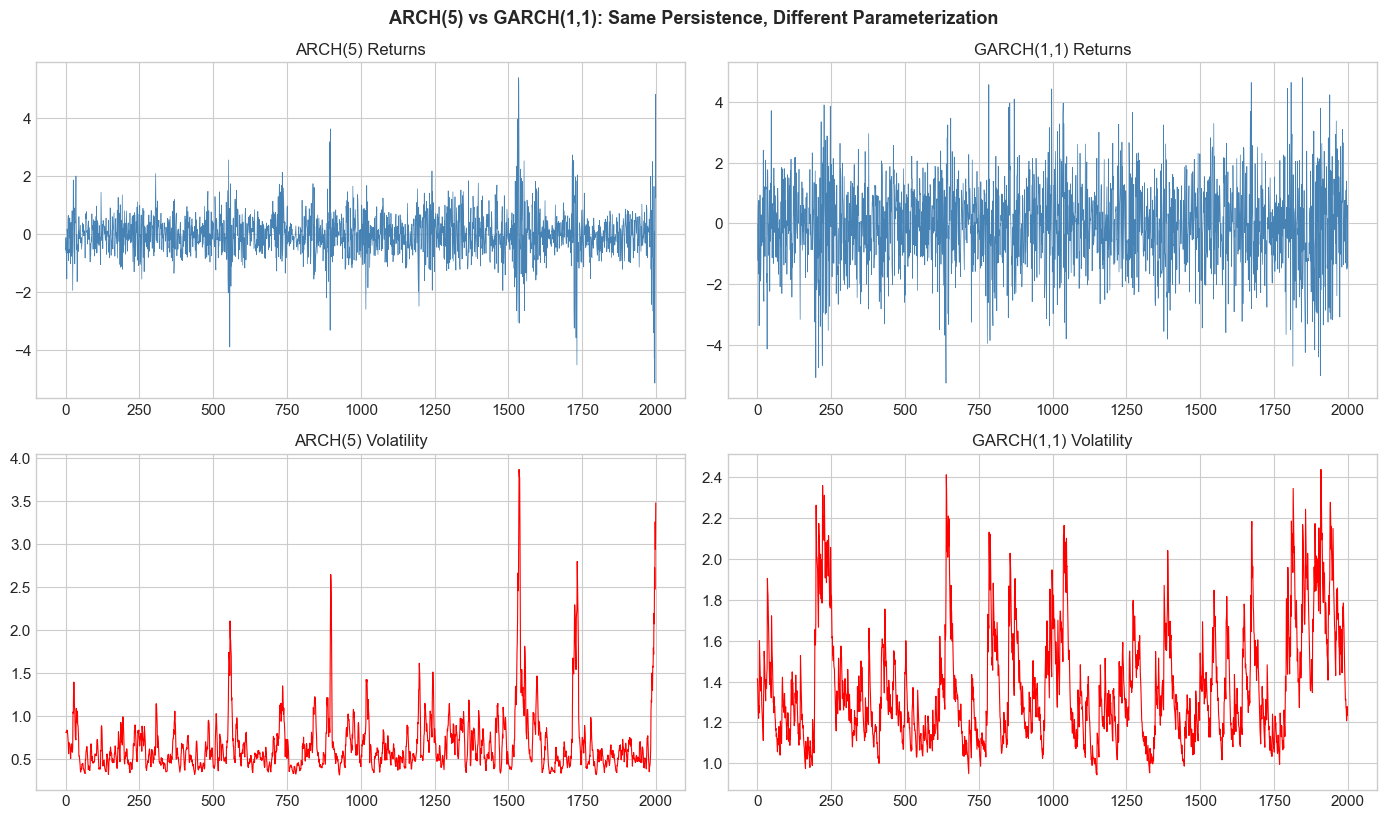

ARCH(5): 6 parameters
GARCH(1,1): 3 parameters
Both have persistence ≈ 0.85


In [7]:
def simulate_garch(n, omega, alphas, betas, dist='normal', df=5):
    """
    Simulate GARCH(p,q) process.
    
    Parameters
    ----------
    n : int
        Number of observations
    omega : float
        Constant term
    alphas : array-like
        ARCH coefficients
    betas : array-like
        GARCH coefficients
    dist : str
        Distribution of innovations
    df : int
        Degrees of freedom for t-distribution
    
    Returns
    -------
    eps, sigma2 : np.arrays
    """
    q = len(alphas)
    p = len(betas)
    max_lag = max(p, q)
    
    eps = np.zeros(n)
    sigma2 = np.zeros(n)
    
    if dist == 'normal':
        z = np.random.standard_normal(n)
    else:
        z = np.random.standard_t(df, n) / np.sqrt(df / (df - 2))
    
    # Unconditional variance
    uncond_var = omega / (1 - np.sum(alphas) - np.sum(betas))
    sigma2[:max_lag] = uncond_var
    eps[:max_lag] = np.sqrt(uncond_var) * z[:max_lag]
    
    for t in range(max_lag, n):
        arch_term = np.sum(alphas * eps[t-q:t][::-1]**2) if q > 0 else 0
        garch_term = np.sum(betas * sigma2[t-p:t][::-1]) if p > 0 else 0
        sigma2[t] = omega + arch_term + garch_term
        eps[t] = np.sqrt(sigma2[t]) * z[t]
    
    return eps, sigma2

# Compare ARCH(5) vs GARCH(1,1) with similar persistence
n = 2000

# ARCH(5) with persistence ≈ 0.85
alphas_arch5 = np.array([0.20, 0.20, 0.20, 0.15, 0.10])  # sum = 0.85
eps_arch5, sigma2_arch5 = simulate_arch(n, 0.1, alphas_arch5)

# GARCH(1,1) with persistence = 0.85
alpha_garch = 0.10
beta_garch = 0.85
eps_garch, sigma2_garch = simulate_garch(n, 0.1, [alpha_garch], [beta_garch])

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0,0].plot(eps_arch5, color='steelblue', linewidth=0.5)
axes[0,0].set_title('ARCH(5) Returns', fontsize=12)

axes[0,1].plot(eps_garch, color='steelblue', linewidth=0.5)
axes[0,1].set_title('GARCH(1,1) Returns', fontsize=12)

axes[1,0].plot(np.sqrt(sigma2_arch5), color='red', linewidth=0.8)
axes[1,0].set_title('ARCH(5) Volatility', fontsize=12)

axes[1,1].plot(np.sqrt(sigma2_garch), color='red', linewidth=0.8)
axes[1,1].set_title('GARCH(1,1) Volatility', fontsize=12)

plt.tight_layout()
plt.suptitle('ARCH(5) vs GARCH(1,1): Same Persistence, Different Parameterization', 
             y=1.02, fontsize=13, fontweight='bold')
plt.show()

print(f"ARCH(5): {len(alphas_arch5)+1} parameters")
print(f"GARCH(1,1): 3 parameters")
print(f"Both have persistence ≈ {np.sum(alphas_arch5):.2f}")

## 3. Maximum Likelihood Estimation

### 3.1 The Likelihood Function

Assuming $z_t \sim N(0,1)$, the conditional density of $\epsilon_t$ is:

$$f(\epsilon_t | \mathcal{F}_{t-1}) = \frac{1}{\sqrt{2\pi\sigma_t^2}} \exp\left(-\frac{\epsilon_t^2}{2\sigma_t^2}\right)$$

The **log-likelihood** function is:

$$\ell(\theta) = \sum_{t=1}^{T} \ln f(\epsilon_t | \mathcal{F}_{t-1}) = -\frac{T}{2}\ln(2\pi) - \frac{1}{2}\sum_{t=1}^{T}\left(\ln\sigma_t^2 + \frac{\epsilon_t^2}{\sigma_t^2}\right)$$

### 3.2 Student-t Innovations

For heavier tails, use standardized Student-t distribution:

$$f(z; \nu) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\pi(\nu-2)}\Gamma\left(\frac{\nu}{2}\right)}\left(1 + \frac{z^2}{\nu-2}\right)^{-\frac{\nu+1}{2}}$$

The log-likelihood becomes:

$$\ell(\theta, \nu) = T\ln\Gamma\left(\frac{\nu+1}{2}\right) - T\ln\Gamma\left(\frac{\nu}{2}\right) - \frac{T}{2}\ln(\pi(\nu-2)) - \frac{1}{2}\sum_{t=1}^{T}\ln\sigma_t^2 - \frac{\nu+1}{2}\sum_{t=1}^{T}\ln\left(1 + \frac{\epsilon_t^2}{(\nu-2)\sigma_t^2}\right)$$

In [10]:
def garch_log_likelihood(params, returns, p=1, q=1, dist='normal'):
    """
    Compute negative log-likelihood for GARCH(p,q) model.
    
    Parameters
    ----------
    params : array
        [omega, alpha_1,...,alpha_q, beta_1,...,beta_p, (df if t-dist)]
    returns : array
        Return series (demeaned)
    p : int
        GARCH order
    q : int
        ARCH order
    dist : str
        'normal' or 't'
    
    Returns
    -------
    float
        Negative log-likelihood
    """
    T = len(returns)
    omega = params[0]
    alphas = params[1:1+q]
    betas = params[1+q:1+q+p]
    
    if dist == 't':
        df = params[-1]
        if df <= 2:
            return 1e10
    
    # Check parameter constraints
    if omega <= 0 or np.any(alphas < 0) or np.any(betas < 0):
        return 1e10
    if np.sum(alphas) + np.sum(betas) >= 1:
        return 1e10
    
    # Initialize variance
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(returns)  # Sample variance as initial
    
    # Compute conditional variances
    for t in range(1, T):
        sigma2[t] = omega
        for i in range(q):
            if t - i - 1 >= 0:
                sigma2[t] += alphas[i] * returns[t-i-1]**2
        for j in range(p):
            if t - j - 1 >= 0:
                sigma2[t] += betas[j] * sigma2[t-j-1]
    
    # Compute log-likelihood
    if dist == 'normal':
        ll = -0.5 * np.sum(np.log(2 * np.pi) + np.log(sigma2) + returns**2 / sigma2)
    else:  # t-distribution
        from scipy.special import gammaln
        ll = T * (gammaln((df+1)/2) - gammaln(df/2) - 0.5*np.log(np.pi*(df-2)))
        ll -= 0.5 * np.sum(np.log(sigma2))
        ll -= ((df+1)/2) * np.sum(np.log(1 + returns**2 / ((df-2)*sigma2)))
    
    return -ll  # Return negative for minimization


def fit_garch(returns, p=1, q=1, dist='normal'):
    """
    Fit GARCH(p,q) model by maximum likelihood.
    
    Returns
    -------
    dict with 'params', 'sigma2', 'loglik', 'aic', 'bic'
    """
    returns = np.asarray(returns)
    T = len(returns)
    
    # Initial parameter guesses
    var_returns = np.var(returns)
    omega_init = var_returns * 0.05
    alpha_init = [0.1] * q
    beta_init = [0.8 / p] * p
    
    if dist == 'normal':
        params_init = [omega_init] + alpha_init + beta_init
    else:
        params_init = [omega_init] + alpha_init + beta_init + [8.0]  # df
    
    # Optimize
    result = minimize(
        garch_log_likelihood,
        params_init,
        args=(returns, p, q, dist),
        method='Nelder-Mead',
        options={'maxiter': 10000}
    )
    
    # Refine with BFGS
    result = minimize(
        garch_log_likelihood,
        result.x,
        args=(returns, p, q, dist),
        method='BFGS',
        options={'maxiter': 5000}
    )
    
    params = result.x
    loglik = -result.fun
    
    # Compute fitted variances
    omega = params[0]
    alphas = params[1:1+q]
    betas = params[1+q:1+q+p]
    
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(returns)
    
    for t in range(1, T):
        sigma2[t] = omega
        for i in range(q):
            if t - i - 1 >= 0:
                sigma2[t] += alphas[i] * returns[t-i-1]**2
        for j in range(p):
            if t - j - 1 >= 0:
                sigma2[t] += betas[j] * sigma2[t-j-1]
    
    # Information criteria
    k = len(params)
    aic = -2 * loglik + 2 * k
    bic = -2 * loglik + k * np.log(T)
    
    return {
        'params': params,
        'omega': omega,
        'alphas': alphas,
        'betas': betas,
        'sigma2': sigma2,
        'loglik': loglik,
        'aic': aic,
        'bic': bic,
        'persistence': np.sum(alphas) + np.sum(betas)
    }

In [12]:
# Test on simulated data
true_omega = 0.05
true_alpha = 0.10
true_beta = 0.85

np.random.seed(42)
sim_returns, true_sigma2 = simulate_garch(2000, true_omega, [true_alpha], [true_beta])

# Fit GARCH(1,1)
result = fit_garch(sim_returns, p=1, q=1, dist='normal')

print("GARCH(1,1) Estimation Results (Simulated Data)")
print("="*50)
print(f"\nTrue parameters:")
print(f"  ω = {true_omega:.6f}")
print(f"  α = {true_alpha:.6f}")
print(f"  β = {true_beta:.6f}")
print(f"\nEstimated parameters:")
print(f"  ω = {result['omega']:.6f}")
print(f"  α = {result['alphas'][0]:.6f}")
print(f"  β = {result['betas'][0]:.6f}")
print(f"\nPersistence (α + β): {result['persistence']:.4f}")
print(f"Log-likelihood: {result['loglik']:.2f}")

GARCH(1,1) Estimation Results (Simulated Data)

True parameters:
  ω = 0.050000
  α = 0.100000
  β = 0.850000

Estimated parameters:
  ω = 0.086825
  α = 0.100369
  β = 0.802914

Persistence (α + β): 0.9033
Log-likelihood: -2682.81


## 4. Empirical Application: S&P 500

In [15]:
# Download S&P 500 data
spy = yf.download('SPY', start='2010-01-01', end='2024-12-31', progress=False)
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = spy.columns.get_level_values(0)

spy['returns'] = np.log(spy['Close'] / spy['Close'].shift(1))
returns = spy['returns'].dropna()

# Demean returns
returns_dm = returns - returns.mean()

print(f"Sample period: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Number of observations: {len(returns)}")
print(f"Mean return: {returns.mean()*100:.4f}%")
print(f"Std deviation: {returns.std()*100:.4f}%")
print(f"Annualized volatility: {returns.std()*np.sqrt(252)*100:.2f}%")

YF.download() has changed argument auto_adjust default to True
Sample period: 2010-01-05 to 2024-12-30
Number of observations: 3772
Mean return: 0.0510%
Std deviation: 1.0774%
Annualized volatility: 17.10%


In [16]:
# Use arch library for estimation with standard errors
from arch import arch_model

# Fit with arch library (scale returns to percentage for numerical stability)
model = arch_model(returns * 100, vol='Garch', p=1, q=1, dist='Normal')
fitted = model.fit(disp='off')

print("\nGARCH(1,1) Estimation (Normal innovations)")
print("="*50)
print(fitted.summary().tables[1])


GARCH(1,1) Estimation (Normal innovations)
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0864  1.216e-02      7.109  1.171e-12 [6.260e-02,  0.110]


In [18]:
# Compare with Student-t innovations
model_t = arch_model(returns * 100, vol='Garch', p=1, q=1, dist='t')
fitted_t = model_t.fit(disp='off')

print("\nGARCH(1,1) Estimation (Student-t innovations)")
print("="*50)
print(fitted_t.summary().tables[1])

print(f"\n\nModel Comparison:")
print(f"Normal:    AIC = {fitted.aic:.2f}, BIC = {fitted.bic:.2f}")
print(f"Student-t: AIC = {fitted_t.aic:.2f}, BIC = {fitted_t.bic:.2f}")
print(f"\nStudent-t degrees of freedom: {fitted_t.params['nu']:.2f}")


GARCH(1,1) Estimation (Student-t innovations)
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1023  1.057e-02      9.675  3.834e-22 [8.156e-02,  0.123]


Model Comparison:
Normal:    AIC = 9650.08, BIC = 9675.02
Student-t: AIC = 9433.92, BIC = 9465.10

Student-t degrees of freedom: 5.51


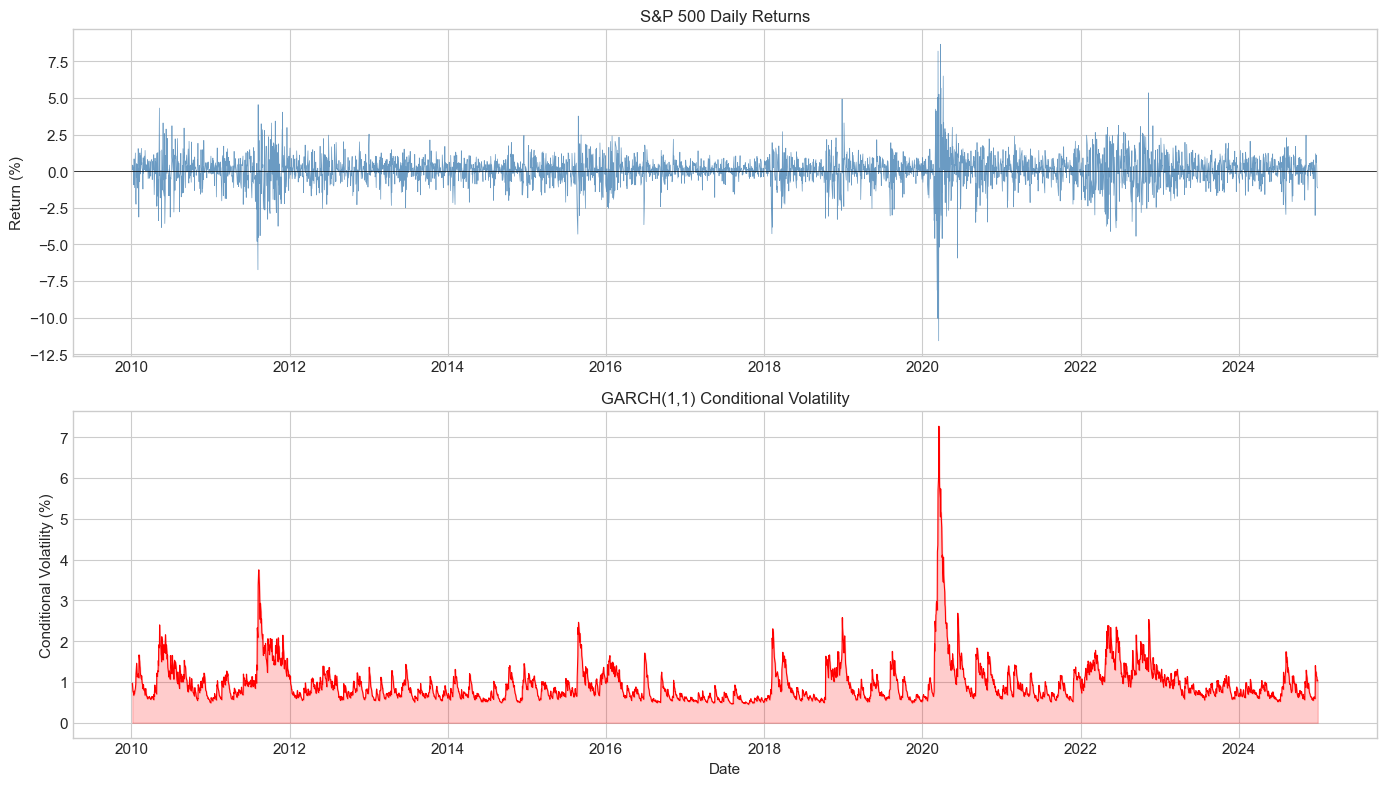

In [19]:
# Plot conditional volatility
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Returns
axes[0].plot(returns.index, returns.values * 100, color='steelblue', 
             linewidth=0.5, alpha=0.8)
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].set_ylabel('Return (%)')
axes[0].set_title('S&P 500 Daily Returns', fontsize=12)

# Conditional volatility
cond_vol = fitted.conditional_volatility
axes[1].plot(returns.index, cond_vol, color='red', linewidth=0.8)
axes[1].fill_between(returns.index, 0, cond_vol, color='red', alpha=0.2)
axes[1].set_ylabel('Conditional Volatility (%)')
axes[1].set_title('GARCH(1,1) Conditional Volatility', fontsize=12)
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

## 5. Model Diagnostics

### 5.1 Standardized Residuals

If the model is correctly specified, the standardized residuals:

$$\hat{z}_t = \frac{\epsilon_t}{\hat{\sigma}_t}$$

should be i.i.d. with mean 0 and variance 1.

### 5.2 Diagnostic Tests

1. **Ljung-Box test on $\hat{z}_t$**: Test for remaining autocorrelation in returns
2. **Ljung-Box test on $\hat{z}_t^2$**: Test for remaining ARCH effects
3. **Normality test**: Jarque-Bera on $\hat{z}_t$

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf

def garch_diagnostics(fitted_model):
    """
    Perform diagnostic tests on GARCH residuals.
    """
    std_resid = fitted_model.std_resid
    
    print("GARCH Model Diagnostics")
    print("="*60)
    
    # Summary statistics of standardized residuals
    print("\n1. Standardized Residuals Summary:")
    print(f"   Mean: {std_resid.mean():.4f} (should be ≈ 0)")
    print(f"   Std:  {std_resid.std():.4f} (should be ≈ 1)")
    print(f"   Skew: {stats.skew(std_resid):.4f}")
    print(f"   Kurt: {stats.kurtosis(std_resid):.4f} (excess)")
    
    # Normality test
    jb_stat, jb_pval = jarque_bera(std_resid)
    print(f"\n2. Jarque-Bera Normality Test:")
    print(f"   Statistic: {jb_stat:.2f}")
    print(f"   p-value:   {jb_pval:.6f}")
    print(f"   Result:    {'Reject H0 (non-normal)' if jb_pval < 0.05 else 'Fail to reject H0'}")
    
    # Ljung-Box on standardized residuals
    lb_resid = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)
    print(f"\n3. Ljung-Box Test on Standardized Residuals:")
    print(f"   Lag 10: Q = {lb_resid['lb_stat'].iloc[0]:.2f}, p = {lb_resid['lb_pvalue'].iloc[0]:.4f}")
    print(f"   Lag 20: Q = {lb_resid['lb_stat'].iloc[1]:.2f}, p = {lb_resid['lb_pvalue'].iloc[1]:.4f}")
    
    # Ljung-Box on squared standardized residuals (ARCH effects)
    lb_sq = acorr_ljungbox(std_resid**2, lags=[10, 20], return_df=True)
    print(f"\n4. Ljung-Box Test on Squared Standardized Residuals:")
    print(f"   Lag 10: Q = {lb_sq['lb_stat'].iloc[0]:.2f}, p = {lb_sq['lb_pvalue'].iloc[0]:.4f}")
    print(f"   Lag 20: Q = {lb_sq['lb_stat'].iloc[1]:.2f}, p = {lb_sq['lb_pvalue'].iloc[1]:.4f}")
    
    return std_resid

std_resid = garch_diagnostics(fitted)

GARCH Model Diagnostics

1. Standardized Residuals Summary:
   Mean: -0.0509 (should be ≈ 0)
   Std:  0.9986 (should be ≈ 1)
   Skew: -0.6267
   Kurt: 1.8564 (excess)

2. Jarque-Bera Normality Test:
   Statistic: 788.54
   p-value:   0.000000
   Result:    Reject H0 (non-normal)

3. Ljung-Box Test on Standardized Residuals:
   Lag 10: Q = 11.65, p = 0.3088
   Lag 20: Q = 25.22, p = 0.1930

4. Ljung-Box Test on Squared Standardized Residuals:
   Lag 10: Q = 7.41, p = 0.6860
   Lag 20: Q = 10.70, p = 0.9537


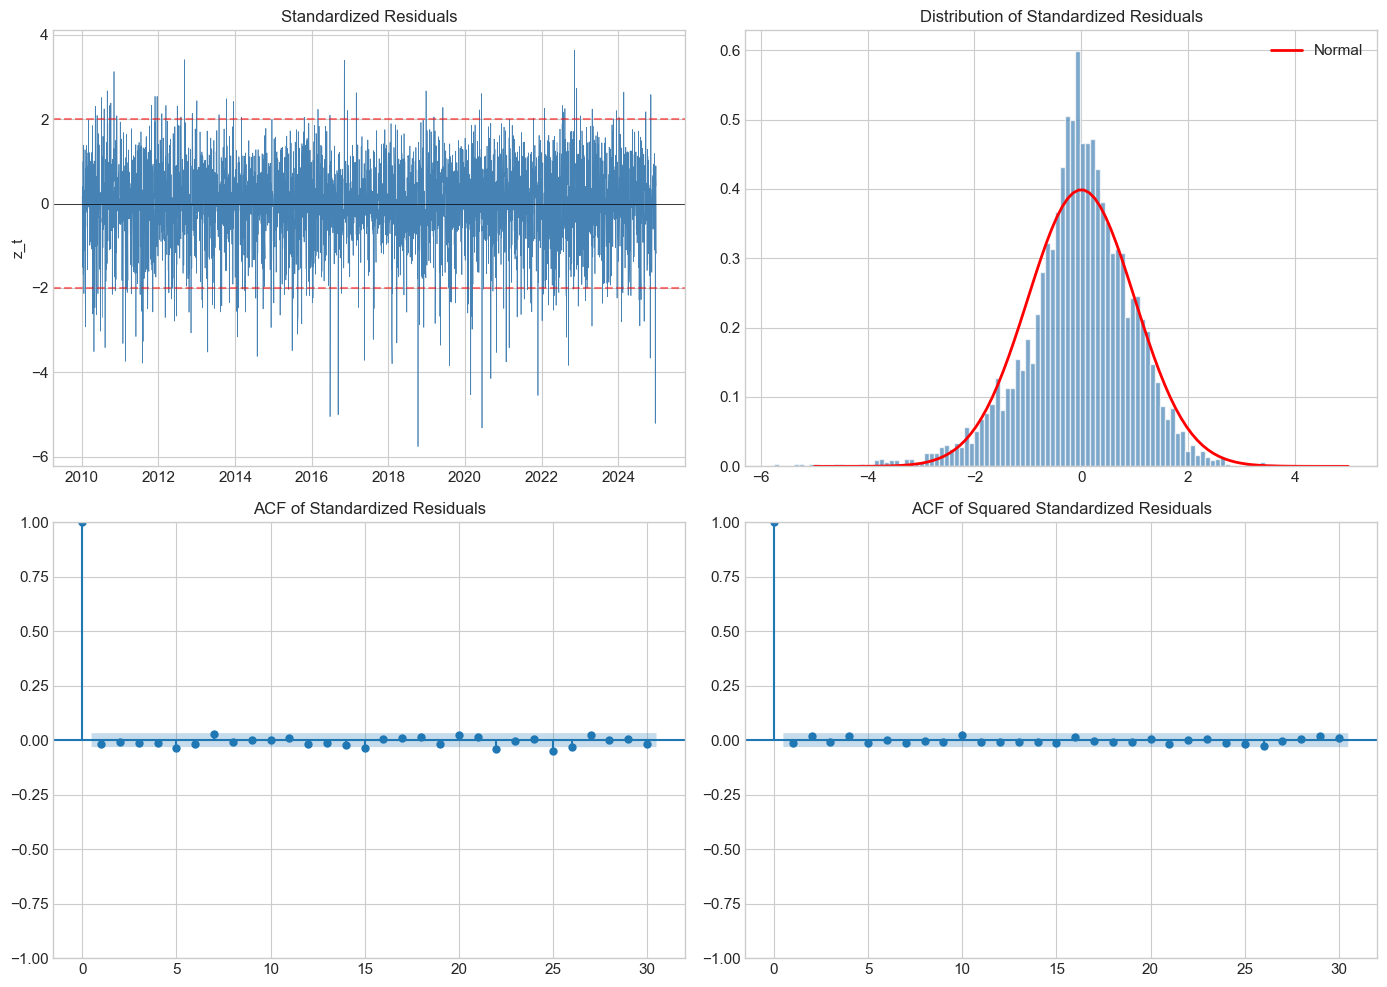

In [24]:
# Visual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series of standardized residuals
axes[0,0].plot(returns.index, std_resid, color='steelblue', linewidth=0.5)
axes[0,0].axhline(0, color='black', linewidth=0.5)
axes[0,0].axhline(2, color='red', linestyle='--', alpha=0.5)
axes[0,0].axhline(-2, color='red', linestyle='--', alpha=0.5)
axes[0,0].set_title('Standardized Residuals', fontsize=12)
axes[0,0].set_ylabel('z_t')

# Histogram vs Normal
axes[0,1].hist(std_resid, bins=100, density=True, alpha=0.7, 
               color='steelblue', edgecolor='white')
x = np.linspace(-5, 5, 100)
axes[0,1].plot(x, norm.pdf(x), 'r-', lw=2, label='Normal')
axes[0,1].set_title('Distribution of Standardized Residuals', fontsize=12)
axes[0,1].legend()

# ACF of standardized residuals
plot_acf(std_resid, lags=30, ax=axes[1,0], alpha=0.05)
axes[1,0].set_title('ACF of Standardized Residuals', fontsize=12)

# ACF of squared standardized residuals
plot_acf(std_resid**2, lags=30, ax=axes[1,1], alpha=0.05)
axes[1,1].set_title('ACF of Squared Standardized Residuals', fontsize=12)

plt.tight_layout()
plt.show()

## 6. Model Selection

### 6.1 Information Criteria

**Akaike Information Criterion (AIC)**:
$$AIC = -2 \ell(\hat{\theta}) + 2k$$

**Bayesian Information Criterion (BIC)**:
$$BIC = -2 \ell(\hat{\theta}) + k \ln(T)$$

where $k$ is the number of parameters and $T$ is the sample size.

BIC penalizes complexity more heavily and tends to select more parsimonious models.

In [28]:
# Model selection: Compare different GARCH specifications
specifications = [
    (1, 1, 'Normal'),
    (1, 1, 't'),
    (1, 2, 'Normal'),
    (1, 2, 't'),
    (2, 1, 'Normal'),
    (2, 1, 't'),
    (2, 2, 'Normal'),
    (2, 2, 't'),
]

results = []
for p, q, dist in specifications:
    model = arch_model(returns * 100, vol='Garch', p=p, q=q, dist=dist)
    fit = model.fit(disp='off')
    results.append({
        'Model': f'GARCH({p},{q})',
        'Distribution': dist,
        'Log-Lik': fit.loglikelihood,
        'AIC': fit.aic,
        'BIC': fit.bic,
        'Params': fit.num_params
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('BIC')

print("Model Selection Results")
print("="*70)
print(results_df.to_string(index=False))
print(f"\nBest model by BIC: {results_df.iloc[0]['Model']} with {results_df.iloc[0]['Distribution']} innovations")

Model Selection Results
     Model Distribution      Log-Lik         AIC         BIC  Params
GARCH(1,1)            t -4711.959934 9433.919868 9465.096671       5
GARCH(2,1)            t -4708.599087 9429.198175 9466.610339       6
GARCH(1,2)            t -4711.959934 9435.919868 9473.332032       6
GARCH(2,2)            t -4708.324808 9430.649616 9474.297140       7
GARCH(1,1)       Normal -4821.041592 9650.083185 9675.024628       4
GARCH(2,1)       Normal -4819.078583 9648.157167 9679.333970       5
GARCH(1,2)       Normal -4821.041593 9652.083185 9683.259988       5
GARCH(2,2)       Normal -4818.129509 9648.259018 9685.671182       6

Best model by BIC: GARCH(1,1) with t innovations


## 7. Volatility Forecasting

### 7.1 Multi-Step Forecasts

For GARCH(1,1), the h-step ahead forecast is:

$$E_t[\sigma_{t+h}^2] = \bar{\sigma}^2 + (\alpha_1 + \beta_1)^{h-1}(\sigma_{t+1}^2 - \bar{\sigma}^2)$$

where $\bar{\sigma}^2 = \omega / (1 - \alpha_1 - \beta_1)$ is the unconditional variance.

As $h \to \infty$, $E_t[\sigma_{t+h}^2] \to \bar{\sigma}^2$.

### 7.2 Forecast Evaluation

Since volatility is latent, we need proxies:
- Squared returns: $r_t^2$ (noisy but unbiased)
- Realized variance (high-frequency data)
- Implied volatility (from options)

In [30]:
# Generate volatility forecasts
forecast_horizon = 22  # 1 month ahead

# Fit model on data up to a point and forecast
train_end = '2023-12-31'
returns_train = returns[returns.index <= train_end]
returns_test = returns[returns.index > train_end]

model = arch_model(returns_train * 100, vol='Garch', p=1, q=1, dist='t')
fitted = model.fit(disp='off')

# Multi-step forecast
forecasts = fitted.forecast(horizon=forecast_horizon, reindex=False)

print("Volatility Forecasts (% per day)")
print("="*40)
print(f"1-day ahead: {np.sqrt(forecasts.variance.iloc[-1, 0]):.4f}%")
print(f"5-day ahead: {np.sqrt(forecasts.variance.iloc[-1, 4]):.4f}%")
print(f"22-day ahead: {np.sqrt(forecasts.variance.iloc[-1, -1]):.4f}%")

# Unconditional volatility
omega = fitted.params['omega']
alpha = fitted.params['alpha[1]']
beta = fitted.params['beta[1]']
uncond_vol = np.sqrt(omega / (1 - alpha - beta))
print(f"\nUnconditional volatility: {uncond_vol:.4f}%")

Volatility Forecasts (% per day)
1-day ahead: 0.6337%
5-day ahead: 0.6960%
22-day ahead: 0.9023%

Unconditional volatility: 1.9216%


In [32]:
# Rolling forecast evaluation
def rolling_forecast_evaluation(returns, window=1000, horizon=1):
    """
    Perform rolling 1-step ahead forecasts and compare to realized volatility.
    """
    forecasted_vol = []
    realized_vol = []
    dates = []
    
    returns_array = returns * 100  # Convert to percentage
    
    for t in range(window, len(returns_array) - horizon):
        # Fit on rolling window
        train = returns_array.iloc[t-window:t]
        
        try:
            model = arch_model(train, vol='Garch', p=1, q=1, dist='Normal')
            fit = model.fit(disp='off', show_warning=False)
            
            # 1-step forecast
            fcast = fit.forecast(horizon=horizon, reindex=False)
            forecasted_vol.append(np.sqrt(fcast.variance.iloc[-1, -1]))
            
            # Realized volatility proxy: absolute return
            realized_vol.append(np.abs(returns_array.iloc[t + horizon - 1]))
            dates.append(returns_array.index[t + horizon - 1])
        except:
            continue
    
    return pd.DataFrame({
        'forecasted': forecasted_vol,
        'realized': realized_vol
    }, index=dates)

# Run rolling evaluation (subset for speed)
returns_subset = returns['2020-01-01':'2024-12-31']
eval_df = rolling_forecast_evaluation(returns_subset, window=500, horizon=1)

# Compute forecast evaluation metrics
mse = np.mean((eval_df['forecasted'] - eval_df['realized'])**2)
mae = np.mean(np.abs(eval_df['forecasted'] - eval_df['realized']))
corr = eval_df['forecasted'].corr(eval_df['realized'])

print("Forecast Evaluation (1-day ahead)")
print("="*40)
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Correlation: {corr:.4f}")

Forecast Evaluation (1-day ahead)
MSE: 0.5660
MAE: 0.6038
Correlation: 0.3263


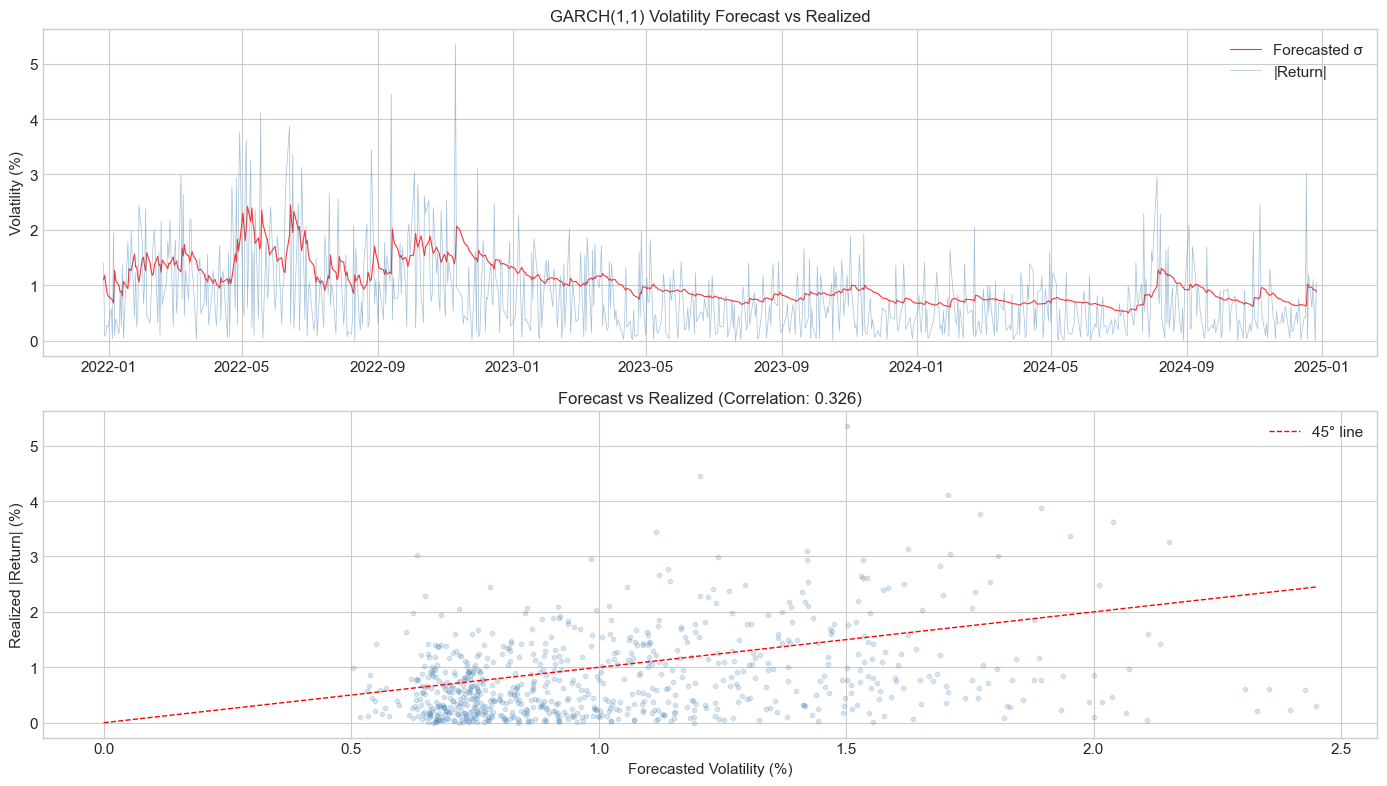

In [34]:
# Plot forecast vs realized
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Time series comparison
axes[0].plot(eval_df.index, eval_df['forecasted'], color='red', 
             linewidth=0.8, label='Forecasted σ', alpha=0.8)
axes[0].plot(eval_df.index, eval_df['realized'], color='steelblue', 
             linewidth=0.5, label='|Return|', alpha=0.5)
axes[0].set_title('GARCH(1,1) Volatility Forecast vs Realized', fontsize=12)
axes[0].set_ylabel('Volatility (%)')
axes[0].legend()

# Scatter plot
axes[1].scatter(eval_df['forecasted'], eval_df['realized'], 
                alpha=0.2, s=10, color='steelblue')
axes[1].plot([0, eval_df['forecasted'].max()], [0, eval_df['forecasted'].max()], 
             'r--', linewidth=1, label='45° line')
axes[1].set_xlabel('Forecasted Volatility (%)')
axes[1].set_ylabel('Realized |Return| (%)')
axes[1].set_title(f'Forecast vs Realized (Correlation: {corr:.3f})', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Integrated GARCH (IGARCH)

When $\alpha_1 + \beta_1 = 1$, we have the **Integrated GARCH** model. This implies:

1. Shocks to volatility persist forever
2. Unconditional variance is infinite
3. Volatility forecasts don't revert to a long-run mean

The **EWMA** model is a special case: IGARCH(1,1) with no constant:

$$\sigma_t^2 = (1-\lambda) \epsilon_{t-1}^2 + \lambda \sigma_{t-1}^2$$

where $\lambda = \beta_1$ and $\alpha_1 = 1 - \lambda$.

In [41]:
# Compare GARCH vs IGARCH forecasts
# Standard GARCH(1,1)
model_garch = arch_model(returns * 100, vol='Garch', p=1, q=1)
fit_garch = model_garch.fit(disp='off')

# EWMA (RiskMetrics) - IGARCH with lambda=0.94
model_ewma = arch_model(returns * 100, vol='EWMA')#, lam=0.94)
fit_ewma = model_ewma.fit(disp='off')

# Generate long-horizon forecasts
horizon = 100
fcast_garch = fit_garch.forecast(horizon=horizon, reindex=False)
fcast_ewma = fit_ewma.forecast(horizon=horizon, reindex=False)

# Plot forecast paths
fig, ax = plt.subplots(figsize=(12, 6))

days = np.arange(1, horizon + 1)
ax.plot(days, np.sqrt(fcast_garch.variance.iloc[-1].values), 
        'b-', linewidth=2, label='GARCH(1,1)')
ax.plot(days, np.sqrt(fcast_ewma.variance.iloc[-1].values), 
        'r--', linewidth=2, label='EWMA (λ=0.94)')

# Unconditional volatility
omega = fit_garch.params['omega']
alpha = fit_garch.params['alpha[1]']
beta = fit_garch.params['beta[1]']
uncond_vol = np.sqrt(omega / (1 - alpha - beta))
ax.axhline(uncond_vol, color='blue', linestyle=':', alpha=0.5, 
           label=f'GARCH unconditional vol: {uncond_vol:.2f}%')

ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('Forecasted Volatility (%)')
ax.set_title('GARCH vs IGARCH (EWMA): Forecast Mean Reversion', fontsize=13)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nGARCH(1,1) persistence: {alpha + beta:.4f}")
print(f"EWMA persistence: 1.0000 (by construction)")

ValueError: Unknown model type in vol

## 9. Summary

### Key Takeaways

1. **ARCH models** capture volatility clustering by making variance depend on past squared shocks

2. **GARCH** extends ARCH with lagged variance terms, providing a parsimonious representation

3. **Estimation** is done by maximum likelihood; Student-t innovations typically improve fit

4. **Diagnostics** check that standardized residuals are i.i.d.

5. **GARCH(1,1)** is often sufficient for daily financial data

6. **Persistence** ($\alpha + \beta$) determines how quickly volatility reverts to its mean

### Preview of Session 3

GARCH(1,1) has a **symmetric** news impact: positive and negative shocks of the same magnitude have the same effect on volatility. But we know the **leverage effect** exists!

Session 3 covers **asymmetric GARCH models**: EGARCH, GJR-GARCH, TGARCH.

## Exercises

### Exercise 1: Bitcoin GARCH
Fit GARCH(1,1) to Bitcoin daily returns. How does the persistence compare to S&P 500? What does this imply about volatility half-life?

### Exercise 2: Distribution Choice
Compare Normal, Student-t, and Skewed Student-t distributions for S&P 500. Which provides the best fit according to BIC?

### Exercise 3: Higher-Order GARCH
Estimate GARCH(2,2) for S&P 500. Is the improvement in log-likelihood worth the additional parameters?

### Exercise 4: Forecast Evaluation
Implement the Mincer-Zarnowitz regression:
$$RV_t = \alpha + \beta \hat{\sigma}_t^2 + u_t$$
Test H0: $\alpha = 0, \beta = 1$ (unbiased forecasts).

### Exercise 5: IGARCH
Fit IGARCH(1,1) to S&P 500 and compare forecasts with GARCH(1,1) at horizons of 1, 5, 22, and 66 days.

## References

1. Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. *Econometrica*, 50(4), 987-1007.

2. Bollerslev, T. (1986). Generalized autoregressive conditional heteroskedasticity. *Journal of Econometrics*, 31(3), 307-327.

3. Bollerslev, T., Chou, R. Y., & Kroner, K. F. (1992). ARCH modeling in finance: A review of the theory and empirical evidence. *Journal of Econometrics*, 52(1-2), 5-59.

4. Francq, C., & Zakoian, J. M. (2019). *GARCH Models: Structure, Statistical Inference and Financial Applications*. John Wiley & Sons.